# Begining of Basic Image Processing

In [2]:
:dep anyhow = "1.0.66"
:dep opencv = "0.70.0"
:dep image = "0.23"
:dep evcxr_image = "1.1.0"
:dep ndarray = "0.15.6"
:dep nalgebra = "0.31.2"
:dep plotters = { version = "^0.3.0", default_features = false, features = ["evcxr", "all_series"] }
extern crate plotters;

use std::fs;
use std::path::{Path};
use anyhow::{anyhow, Result, Error};
use opencv::prelude::*;
use image::{ImageBuffer, RgbImage, Rgb};
use evcxr_image::ImageDisplay;
use plotters::prelude::*;

#[macro_use]
extern crate nalgebra as na;

fn opencv_imshow(img: &Mat) {
    let img_rgb = RgbImage::new(img.cols() as u32, img.rows() as u32);
    let data: Vec<u8> = img.data_bytes().unwrap().to_vec();
    let channels: u32 = img.channels() as u32;
    image::ImageBuffer::from_fn(img_rgb.width(), img_rgb.height(), | x, y | {
        let yi = y * img_rgb.width();
        let i: usize = ((x + yi) * channels) as usize;
        match channels {
            3 => {
                let b = data[i];
                let g = data[i + 1];
                let r = data[i + 2];
                image::Rgb([r, g, b])
            },
            _ => {
                let b = data[i];
                image::Rgb([b, b, b])
            }
        }
    }).evcxr_display()
}

let image_dir = "opencv_samples/images";

In [3]:
for file in fs::read_dir(image_dir)?.filter_map(|file| file.ok()) {
    println!("{}", file.path().to_path_buf().file_name().unwrap().to_str().unwrap());
  }

Girl.bmp
book_perspective.jpg
alcatraz2.jpg
Univ3.jpg
ceramic-houses_t0.png
Parrots.bmp
Lenna.bmp
milkdrop.bmp
Sailboat.bmp
sf_view1.jpg
Univ5.jpg
checkerboard.png
couple.bmp
alcatraz1.jpg
Pepper.bmp
Aerial.bmp
crans_2_small.jpg
Balloon.bmp
crans_1_small.jpg
book_frontal.jpg
empire.jpg
Univ2.jpg
Univ4.jpg
Mandrill.bmp
sf_view2.jpg
Airplane.bmp
Univ1.jpg
circleboard.jpg
Earth.bmp


()

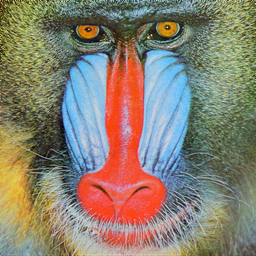

In [4]:
let image_path = Path::new(image_dir).join("Mandrill.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED)?;
opencv_imshow(&img)

In [5]:
println!("height: {}", img.cols());
println!("width: {}", img.rows());
println!("channels: {}", img.channels());

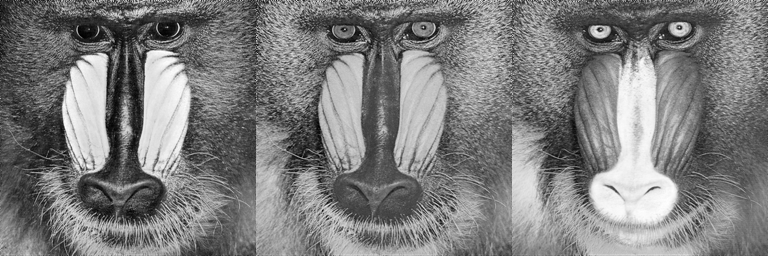

In [6]:
let mut channels: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
opencv::core::split(&img, &mut channels);

let mut dest: Mat = Default::default();
opencv::core::hconcat(&channels, &mut dest).expect("error on concat");
opencv_imshow(&dest)

In [7]:
fn color_hist(img: &Mat) {
    // https://docs.opencv.org/4.6.0/d8/dbc/tutorial_histogram_calculation.html
    let hist_w: i32 = img.rows();
    let hist_h: i32 = img.cols() * 2 + 120;
    evcxr_figure((480, 320), |root| {
        root.fill(&WHITE)?;
        let mut chart = ChartBuilder::on(&root)
            .caption("BGR Histogram", ("Arial", 20).into_font())
            .margin(5)
            .x_label_area_size(30)
            .y_label_area_size(30)
            .build_cartesian_2d(0..hist_w, -30..hist_h)?;
        chart.configure_mesh().draw()?;
        let color = vec!("BLUE", "GREEN", "RED");
        for (i, col) in color.iter().enumerate() {
            let mut hist = Mat::default();
            opencv::imgproc::calc_hist(
                &opencv::types::VectorOfMat::from(vec![img.clone()]), // image array
                &opencv::types::VectorOfi32::from(vec![i as i32]), // channels
                &opencv::core::no_array(), // mask
                &mut hist, // hist output
                &opencv::types::VectorOfi32::from(vec![hist_w]), // hist size
                &opencv::types::VectorOff32::from(vec![0., hist_w as f32]), //ranges
                false // accumulate - default: false
            ).expect("calc histogram failed.");
            let mut hist_dst: Mat = Default::default();
            opencv::core::normalize(&hist, &mut hist_dst, 0., hist_h as f64, opencv::core::NORM_MINMAX, -1, &opencv::core::no_array());
            chart.draw_series(
                match col {
                    &"BLUE" => {
                        LineSeries::new(hist_dst.iter::<f32>().unwrap().map(|(p, v)| (p.y, v as i32)), &BLUE)
                    },
                    &"GREEN" => {
                        LineSeries::new(hist_dst.iter::<f32>().unwrap().map(|(p, v)| (p.y, v as i32)), &GREEN)
                    },
                    _ => {
                        LineSeries::new(hist_dst.iter::<f32>().unwrap().map(|(p, v)| (p.y, v as i32)), &RED)
                    }
                }
            );
        }
        Ok(())
    }).evcxr_display()
}

color_hist(&img)

()

# Different Brightness / Contrast

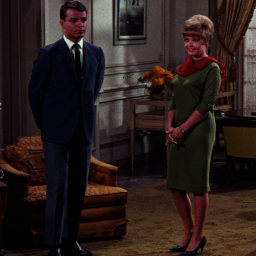

In [8]:
let image_path = Path::new(image_dir).join("couple.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED)?;
opencv_imshow(&img)

In [9]:
color_hist(&img)

()

# Normalize Brightness

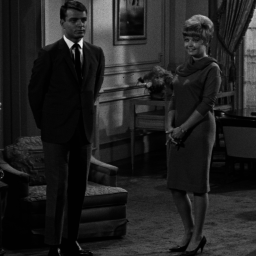

In [10]:
let mut img_gray: Mat = Default::default();
opencv::imgproc::cvt_color(&img, &mut img_gray, opencv::imgproc::COLOR_BGR2GRAY, 0).expect("error on cvt_color");
opencv_imshow(&img_gray)

In [11]:
fn grayscale_hist(img: &Mat) {
    let hist_w: i32 = img.rows();
    let hist_h: i32 = img.cols() * 2 + 120;
    evcxr_figure((480, 320), |root| {
        root.fill(&WHITE)?;
        let mut chart = ChartBuilder::on(&root)
            .caption("Grayscale Histogram", ("Arial", 20).into_font())
            .margin(5)
            .x_label_area_size(30)
            .y_label_area_size(30)
            .build_cartesian_2d(0..hist_w, -30..hist_h)?;
        chart.configure_mesh().draw()?;
        let mut hist = Mat::default();
        opencv::imgproc::calc_hist(
            &opencv::types::VectorOfMat::from(vec![img.clone()]), // image array
            &opencv::types::VectorOfi32::from(vec![0]), // channels
            &opencv::core::no_array(), // mask
            &mut hist, // hist output
            &opencv::types::VectorOfi32::from(vec![256]), // hist size
            &opencv::types::VectorOff32::from(vec![0., 256.]), //ranges
            false // accumulate - default: false
        ).expect("calc histogram failed.");
        let mut hist_dst: Mat = Default::default();
        opencv::core::normalize(&hist, &mut hist_dst, 0., hist_h as f64, opencv::core::NORM_MINMAX, -1, &opencv::core::no_array());
        chart.draw_series(
            LineSeries::new(hist_dst.iter::<f32>().unwrap().map(|(p, v)| (p.y, v as i32)), &BLACK)
        );
        Ok(())
    }).evcxr_display()
}

grayscale_hist(&img)

()

In [12]:
let flattened_raw: Vec<u8> = img_gray.reshape(1, 1)?.to_vec_2d::<u8>()?.get(0).unwrap().to_owned();
let flattened_f64: Vec<f64> = flattened_raw.into_iter().map(|x| x as f64).collect();
let flattened: ndarray::Array<f64, ndarray::Ix1> = ndarray::Array::from_vec(flattened_f64);
let mean = flattened.mean().unwrap();
let std = flattened.std(0.);
println!("mean: {:?}, standard deviation: {:?}", mean, std);


mean: 33.37681579589844, standard deviation: 31.623476143151514


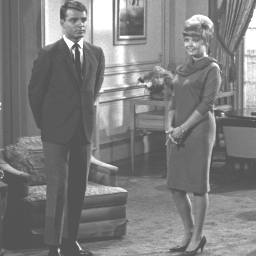

In [13]:
let mut flattened_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in img_gray.iter::<u8>()? {
    let new_v: f64 = 127. + (v as f64 - mean) / (3.0 * std) * 127.;
    if flattened_clamped_vec2.len() < (p.y + 1) as usize {
        flattened_clamped_vec2.push(vec![]);
    }
    flattened_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut flattened_clamped_mat: Mat = Mat::from_slice_2d(&flattened_clamped_vec2)?;
opencv_imshow(&flattened_clamped_mat)

In [14]:
grayscale_hist(&flattened_clamped_mat)

()

# Binarization
* Threshold
* OTSU Method

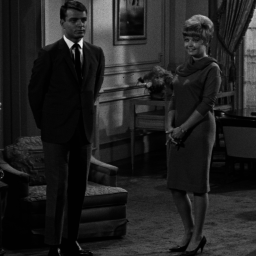

In [15]:
opencv_imshow(&img_gray)

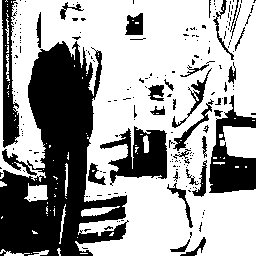

In [16]:
let mut img_gray_bin: Mat = Default::default();

let _ = opencv::imgproc::threshold(
    &img_gray,
    &mut img_gray_bin,
    16., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");
opencv_imshow(&img_gray_bin)

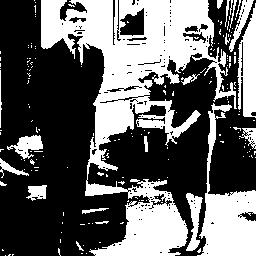

In [17]:
let _ = opencv::imgproc::threshold(
    &img_gray,
    &mut img_gray_bin,
    32., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");
opencv_imshow(&img_gray_bin)

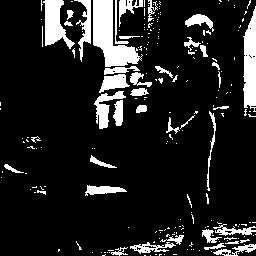

In [18]:
let _ = opencv::imgproc::threshold(
    &img_gray,
    &mut img_gray_bin,
    64., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");
opencv_imshow(&img_gray_bin)

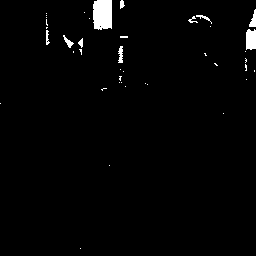

In [19]:
let _ = opencv::imgproc::threshold(
    &img_gray,
    &mut img_gray_bin,
    128., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");
opencv_imshow(&img_gray_bin)

The computed threshold value if Otsu's or Triangle methods used: 46


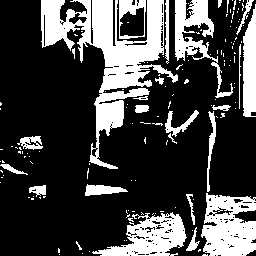

In [20]:
let threshold_value: f64 = opencv::imgproc::threshold(
    &img_gray,
    &mut img_gray_bin,
    0., 255., opencv::imgproc::THRESH_BINARY+opencv::imgproc::THRESH_OTSU)?;
println!("The computed threshold value if Otsu's or Triangle methods used: {}", threshold_value);
opencv_imshow(&img_gray_bin)

# Morphology Operation

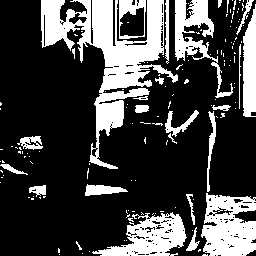

In [21]:
let mut img_gray_bin: Mat = Default::default();
let _: f64 = opencv::imgproc::threshold(
    &img_gray,
    &mut img_gray_bin,
    0., 255., opencv::imgproc::THRESH_BINARY+opencv::imgproc::THRESH_OTSU)?;
opencv_imshow(&img_gray_bin)

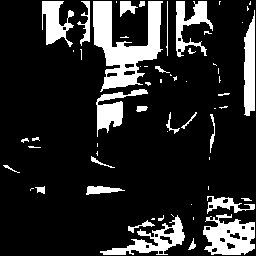

In [22]:
let mut img_gray_erode: Mat = Default::default();
opencv::imgproc::erode(
    &img_gray_bin,
    &mut img_gray_erode,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    1, 0, Default::default()); // 1 is iterations
opencv_imshow(&img_gray_erode)

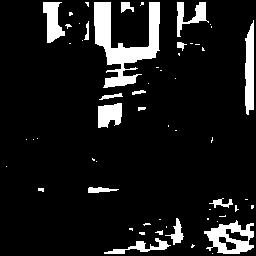

In [23]:
let mut img_gray_erode: Mat = Default::default();
opencv::imgproc::erode(
    &img_gray_bin,
    &mut img_gray_erode,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    2, 0, Default::default()); // 2 is iterations
opencv_imshow(&img_gray_erode)

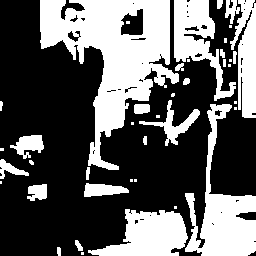

In [24]:
let mut img_gray_dilate: Mat = Default::default();
opencv::imgproc::dilate(
    &img_gray_bin,
    &mut img_gray_dilate,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    1, 0, Default::default()
);
opencv_imshow(&img_gray_dilate)

# Contour Extraction

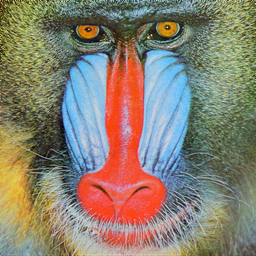

In [25]:
let image_path = Path::new(image_dir).join("Mandrill.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED)?;
opencv_imshow(&img)

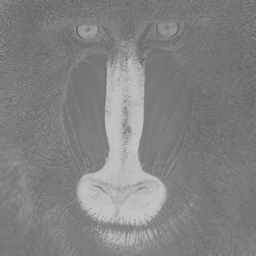

In [26]:
let mut img_lab: Mat = Default::default();
opencv::imgproc::cvt_color(&img, &mut img_lab, opencv::imgproc::COLOR_BGR2Lab, 0).expect("error on cvt_color");

let mut channels_lab: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
// split to Vector<L*A*B channels>.
opencv::core::split(&img_lab, &mut channels_lab).expect("error on split.");
let img_lab_a: Mat = channels_lab.get(1)?.clone().to_owned();
opencv_imshow(&img_lab_a)

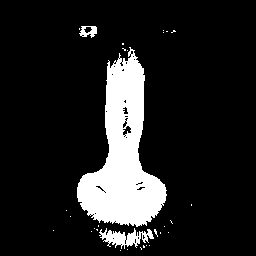

In [27]:
let mut img_lab_a_bin: Mat = Default::default();

let _ = opencv::imgproc::threshold(
    &img_lab_a,
    &mut img_lab_a_bin,
    0., 255., opencv::imgproc::THRESH_BINARY+opencv::imgproc::THRESH_OTSU).expect("threshold failed.");
opencv_imshow(&img_lab_a_bin)

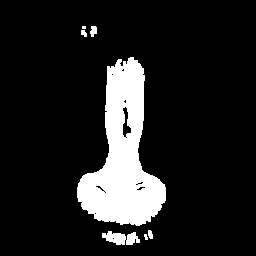

In [28]:
let mut img_erode: Mat = Default::default();
opencv::imgproc::erode(
    &img_lab_a_bin,
    &mut img_erode,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    1, 0, Default::default());
    
let mut img_dilate: Mat = Default::default();
opencv::imgproc::dilate(
    &img_erode,
    &mut img_dilate,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    1, 0, Default::default()
);
opencv_imshow(&img_dilate)

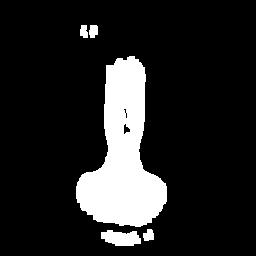

In [29]:
let mut img_erode2: Mat = Default::default();
opencv::imgproc::erode(
    &img_dilate,
    &mut img_erode2,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    2, 0, Default::default()).expect("erode failed.");
    
let mut img_dilate2: Mat = Default::default();
opencv::imgproc::dilate(
    &img_erode,
    &mut img_dilate2,
    &Mat::ones(3, 3, opencv::core::CV_8UC1)?.to_mat()?,
    opencv::core::Point::new(-1, -1),
    2, 0, Default::default()
).expect("dilate failed.");
opencv_imshow(&img_dilate2)

In [30]:
let mut contours: opencv::core::Vector<opencv::core::Vector<opencv::core::Point>> = Default::default();
opencv::imgproc::find_contours(
    &mut img_dilate2,
    &mut contours,
    opencv::imgproc::RETR_TREE,
    opencv::imgproc::CHAIN_APPROX_SIMPLE,
    Default::default()
).expect("find contours failed.");

let mut contours_area_vector: Vec<f32> = Default::default();
for contour in &contours {
    contours_area_vector.push(opencv::imgproc::contour_area(&contour, false)? as f32);
}
let contours_area_dvector: na::DVector<f32> = na::DVector::from_vec(contours_area_vector);
let max_index = contours_area_dvector.argmax().0 as i32;
println!("{:?}", &max_index);


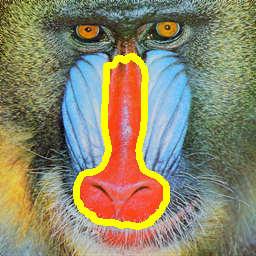

In [31]:
let mut img_contours_result: Mat = img.clone().to_owned();
opencv::imgproc::draw_contours(
    &mut img_contours_result,
    &contours,
    max_index,
    opencv::core::Scalar::new(0.0, 255.0, 255.0, 100.0),
    6,
    0,
    &0.,
    0,
    Default::default()
).expect("draw contours failed.");
opencv_imshow(&img_contours_result)

# Filter: Smoothing

* Box filter
* Median filter
* Gaussian filter
* Bilateral filter

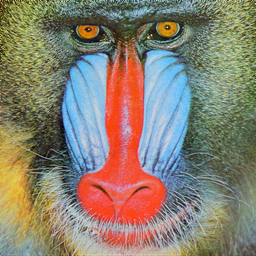

In [32]:
let image_path = Path::new(image_dir).join("Mandrill.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED)?;
opencv_imshow(&img)

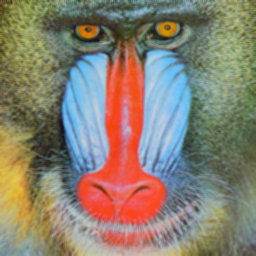

In [33]:
let mut img_blur: Mat = Default::default();
opencv::imgproc::blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(3, 3),
    opencv::core::Point::new(-1, -1),
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

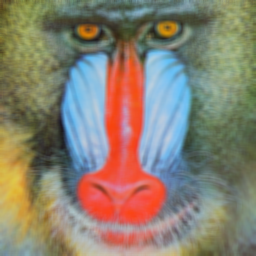

In [34]:
opencv::imgproc::blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(5, 5),
    opencv::core::Point::new(-1, -1),
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

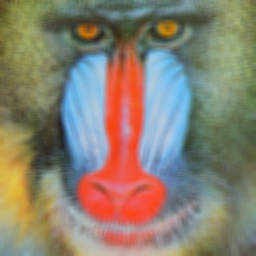

In [35]:
opencv::imgproc::blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(7, 7),
    opencv::core::Point::new(-1, -1),
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

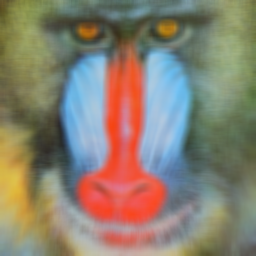

In [36]:
opencv::imgproc::blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(9, 9),
    opencv::core::Point::new(-1, -1),
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

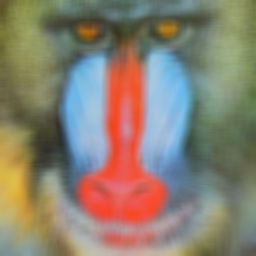

In [37]:
opencv::imgproc::blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(11, 11),
    opencv::core::Point::new(-1, -1),
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

In [38]:
// TODO: generate_noise_image

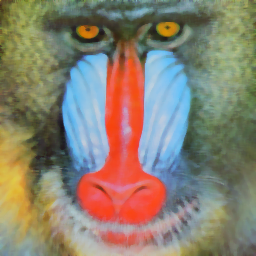

In [39]:
opencv::imgproc::median_blur(
    &img,
    &mut img_blur,
    5
);
opencv_imshow(&img_blur)

In [40]:
// TODO: median_blur with noise image

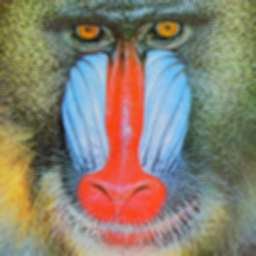

In [41]:
opencv::imgproc::gaussian_blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(5, 5),
    2.,
    0., // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

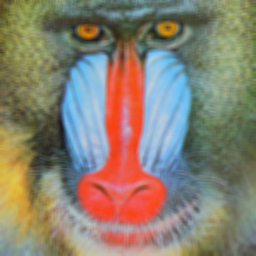

In [42]:
opencv::imgproc::gaussian_blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(5, 5),
    10.,
    0., // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

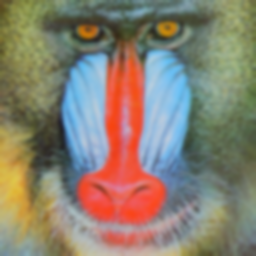

In [43]:
opencv::imgproc::gaussian_blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(11, 11),
    2.,
    0., // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur);

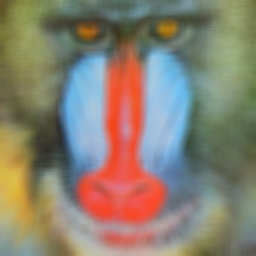

In [44]:
opencv::imgproc::gaussian_blur(
    &img,
    &mut img_blur,
    opencv::core::Size::new(11, 11),
    10.,
    0., // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

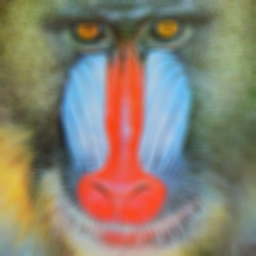

In [45]:
opencv::imgproc::bilateral_filter(
    &img,
    &mut img_blur,
    11,
    100000., // sigma color
    10., // sigma space
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

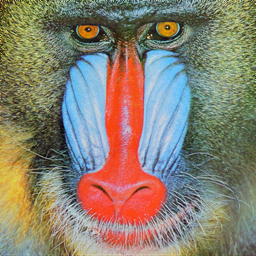

In [46]:
opencv::imgproc::bilateral_filter(
    &img,
    &mut img_blur,
    11,
    1., // sigma color
    10., // sigma space
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

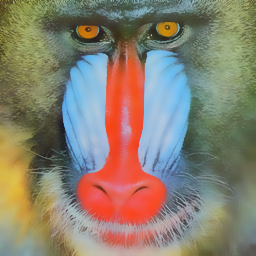

In [47]:
opencv::imgproc::bilateral_filter(
    &img,
    &mut img_blur,
    11,
    100., // sigma color
    10., // sigma space
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv_imshow(&img_blur)

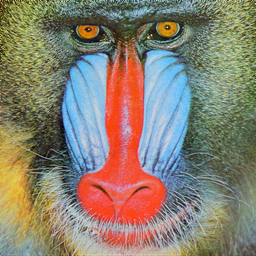

In [48]:
opencv_imshow(&img)

# Filter: Edge Extraction

* Sobel filter
* Laplacian filter

## Sobel filter

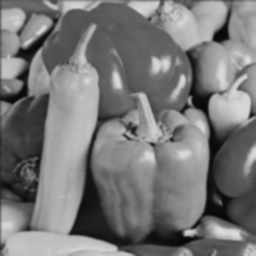

In [49]:
let image_path = Path::new(image_dir).join("Pepper.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED).unwrap();
let mut img_gray: Mat = Default::default();
opencv::imgproc::cvt_color(&img, &mut img_gray, opencv::imgproc::COLOR_BGR2GRAY, 0).expect("error on cvt_color");
let mut img_gray_blur: Mat = Default::default();
opencv::imgproc::gaussian_blur(
    &img_gray,
    &mut img_gray_blur,
    opencv::core::Size::new(0, 0),
    1.0,
    1.0, // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
); // blur for denoise.
opencv_imshow(&img_gray_blur)

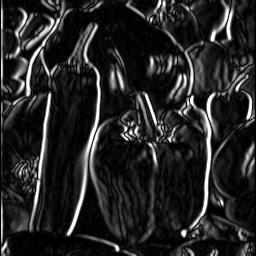

In [50]:
let mut sobel_x: Mat = Default::default();
let mut sobel_x_abs: Mat = Default::default();
opencv::imgproc::sobel(
    &img_gray_blur,
    &mut sobel_x,
    opencv::core::CV_32F, // other types may loose data.
    1, // dx. order of the derivative x.
    0, // dy. order of the derivative y.
    3, // ksize. size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
    1., // scale. default is f1.
    0., // delta. default is f0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
// if we calcuate image as unsigned 8bit, we lost the variance of white to black value. because these are calcuate as negative slope. therefore, we convert negative slope as u8, it results are 0(data loss).
opencv::core::convert_scale_abs(&sobel_x, &mut sobel_x_abs, 1., 0.); // convert to unsigned 8bit for 8bit-RGB output.
opencv_imshow(&sobel_x_abs)

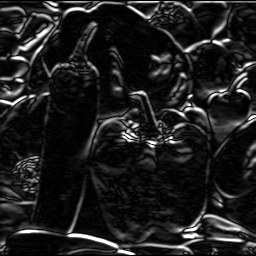

In [51]:
let mut sobel_y: Mat = Default::default();
let mut sobel_y_abs: Mat = Default::default();
opencv::imgproc::sobel(
    &img_gray_blur,
    &mut sobel_y,
    opencv::core::CV_32F,
    0, // dx. order of the derivative x.
    1, // dy. order of the derivative y.
    3, // ksize. size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
    1., // scale. default is f1.
    0., // delta. default is f0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
opencv::core::convert_scale_abs(&sobel_y, &mut sobel_y_abs, 1., 0.);
opencv_imshow(&sobel_y_abs)

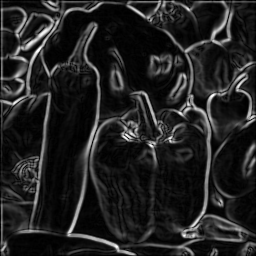

In [52]:
// let mut sobel_x_multi: Mat = Default::default();
// let mut sobel_x_multi_abs: Mat = Default::default();
// opencv::core::multiply(&sobel_x_abs, &sobel_x_abs, &mut sobel_x_multi, 1., -1);
// opencv::core::convert_scale_abs(&sobel_x_multi, &mut sobel_x_multi_abs, 1., 0.);
// let mut sobel_y_multi: Mat = Default::default();
// let mut sobel_y_multi_abs: Mat = Default::default();
// opencv::core::multiply(&sobel_y_abs, &sobel_y_abs, &mut sobel_y_multi, 1., -1);
// opencv::core::convert_scale_abs(&sobel_y_multi, &mut sobel_y_multi_abs, 1., 0.);
let mut sobel_xy: Mat = Default::default();
opencv::core::add_weighted(
    &sobel_x_abs,
    0.5, // default is 0.5
    &sobel_y_abs,
    0.5, // default is 0.5
    0.,
    &mut sobel_xy,
    opencv::core::CV_8U
);
let mut sobel_xy_sqrt: Mat = sobel_xy.clone().to_owned();
let mut sobel_xy_sqrt_abs: Mat = Default::default();
opencv::core::sqrt(&sobel_xy, &mut sobel_xy_sqrt);
opencv_imshow(&sobel_xy_sqrt)

## Laplacian filter

Mat { type: "CV_8UC1", flags: 1124024320, channels: 1, depth: "CV_8U", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 1, elem_size1: 1, total: 65536, is_continuous: true, is_submatrix: false }


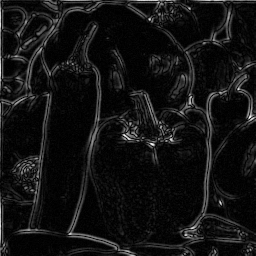

In [53]:
let mut img_laplacian: Mat = Default::default();
let mut img_laplacian_abs: Mat = Default::default();
opencv::imgproc::laplacian(
    &img_gray_blur,
    &mut img_laplacian,
    opencv::core::CV_32F, // other types may loose data.
    3, // ksize. size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
    1., // scale. default is f1.
    0., // delta. default is f0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
// if we calcuate image as unsigned 8bit, we lost the variance of white to black value. because these are calcuate as negative slope. therefore, we convert negative slope as u8, it results are 0(data loss).
opencv::core::convert_scale_abs(&img_laplacian, &mut img_laplacian_abs, 1., 0.); // convert to unsigned 8bit for 8bit-RGB output.
println!("{:?}", &img_laplacian_abs);
opencv_imshow(&img_laplacian_abs)

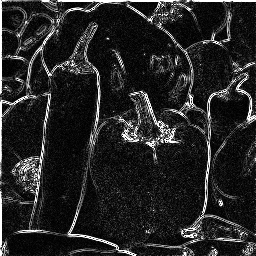

In [54]:
let mut img_filter2d_lap: Mat = Default::default();
let kernel_laplacian: Mat = Mat::from_slice_2d(&[[1. as f32,1.,1.], [1.,-8.,1.], [1.,1.,1.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_gray,
    &mut img_filter2d_lap,
    opencv::core::CV_32F,
    &kernel_laplacian,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_lap_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_lap, &mut img_filter2d_lap_abs, 1., 0.);
opencv_imshow(&img_filter2d_lap_abs)

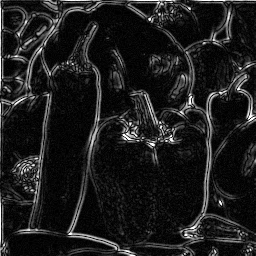

In [55]:
let mut img_gray_gaussian_1: Mat = Default::default();
opencv::imgproc::gaussian_blur(
    &img_gray,
    &mut img_gray_gaussian_1,
    opencv::core::Size::new(5, 5),
    1.0,
    1.0, // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
let mut img_filter2d_gaussian_lap: Mat = Default::default();
opencv::imgproc::filter_2d(
    &img_gray_gaussian_1,
    &mut img_filter2d_gaussian_lap,
    opencv::core::CV_32F,
    &kernel_laplacian,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_gaussian_lap_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_gaussian_lap, &mut img_filter2d_gaussian_lap_abs, 2., 0.);
opencv_imshow(&img_filter2d_gaussian_lap_abs)

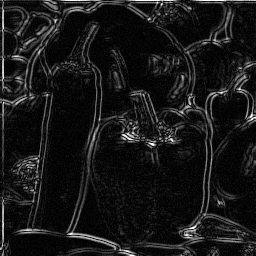

In [56]:
let mut img_gray_gaussian_5: Mat = Default::default();
opencv::imgproc::gaussian_blur(
    &img_gray,
    &mut img_gray_gaussian_5,
    opencv::core::Size::new(5, 5),
    5.0,
    1.0, // the default value of sigma Y is 0.
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32 // BORDER_REFLECT_101 is BORDER_DEFAULT in C, Python OpenCV
);
let mut img_filter2d_gaussian_lap: Mat = Default::default();
opencv::imgproc::filter_2d(
    &img_gray_gaussian_5,
    &mut img_filter2d_gaussian_lap,
    opencv::core::CV_32F,
    &kernel_laplacian,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_gaussian_lap_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_gaussian_lap, &mut img_filter2d_gaussian_lap_abs, 2., 0.);
opencv_imshow(&img_filter2d_gaussian_lap_abs)